# Integration

### Zhentao Shi

<img src="graph/damaoshan.jpeg" width="1000">

<!-- code is tested on SCRP -->

* Mathematically, integration and differentiation involve taking limit
* Computer is a finite-precision machine

* Numerical integration
* Stochastic integration
* Markov Chain Monte Carlo (MCMC)


## Numerical Methods

* Numerical differentiation and integration
* Nothing to do with economics or econometrics

* To find the optimum for the objective function $f:R^K \mapsto R$
by Newton's method, 
  * $K$-dimensional gradient   
  * $K\times K$-dimensional Hessian matrix.

* Programming up the gradient and the Hessian manually is a time-consuming and error-prone job
* Whenever we change the objective function, we have to redo the gradient and Hessian

* More efficient to use numerical differentiation instead of the analytical expressions

The partial derivative of a multivariate function
$f:R^K \mapsto R$ at a point $x_0 \in R^K$ is

$$
\frac{\partial f(x)}{\partial x_k}\bigg|_{x=x_0}=\lim_{\epsilon \to 0}
\frac{f(x_0+\epsilon \cdot e_k) - f(x_0 - \epsilon \cdot e_k)}{2\epsilon},
$$

where $e_k = (0,\ldots,0,1,0,\ldots,0)$ is the identifier of the $k$-th coordinate.

* Numerical execution in a computer follows the basic definition to evaluate
$f(x_0\pm\epsilon \cdot e_k))$ with a small
$\epsilon$. 

* How small is small? Usually we try a sequence of $\epsilon$'s until
the numerical derivative is stable. 

* There are also more sophisticated algorithms.

In R, the package `numDeriv` conducts numerical differentiation, in which

* `grad` for a scalar-valued function;
* `jacobian` for a real-vector-valued function;
* `hessian` for a scalar-valued function;
* `genD` for a real-vector-valued function.

## Integration

* `integrate` carries out one-dimensional quadrature
* `adaptIntegrate` in the package `cubature` deals with multi-dimensional quadrature.


## Caution

* Numerical methods are not panacea
* Not all functions are differentiable or integrable.
* Before turning to numerical methods, it is always imperative to try to understand the behavior of the function at the first place.
* Some symbolic software, such as `Mathematica` or `Wolfram Alpha`, is a useful tool for this purpose. 
* R is weak in symbolic calculation despite the existence of a few packages for this purpose.

## Stochastic Methods

* An alternative to numerical integration is the stochastic methods.
* The underlying principle of stochastic integration is the law of large numbers.

* Let  $\int h(x) d F(x)$ be an integral where $F(x)$ is a probability distribution.
* Approximate the integral by
$\int h(x) d F(x) \approx S^{-1} \sum_{s=1}^S h(x_s)$, where $x_s$ is randomly
generated from $F(x)$.

* When $S$ is large, a law of large numbers gives

$$
S^{-1} \sum_{s=1}^S h(x_s) \stackrel{\mathrm{p}}{\to} E[h(x)] = \int h(x) d F(x).
$$

* If the integration is carried out not in the entire support of $F(x)$ but on a subset $A$, then

$$
\int_A h(x) d F(x) \approx S^{-1} \sum_{s=1}^S h(x_s) \cdot 1\{x_s \in A\},
$$

where $1\{\cdot\}$ is the indicator function.

* In theory, use an $S$ as large as possible.
* In reality, constrained by the computer's memory and computing time.
* No clear guidance of the size of $S$ in practice. 
* Preliminary experiment can help decide an $S$ that produces stable results.

* Stochastic integration is popular in econometrics and statistics, thanks to its convenience in execution.

### Random Variable Generation

* **If the CDF $F(X)$ is known**, we can generate random variables that follow such a distribution.
  * Draw $U$ from  $\mathrm{Uniform}(0,1)$
  * Compute $X = F^{-1}(U)$

## Markov Chain Monte Carlo

* **If the pdf $f(X)$ is known**, we can generate a sample by *importance sampling*
  * [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)
 (MH algorithm) is such a method.
  * MH is one of the [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods.
* It can be implemented in the R package `mcmc`.
  * [This page](https://chi-feng.github.io/mcmc-demo/) contains demonstrative
examples of MCMC.

### Metropolis-Hastings Algorithm

* Theory of the MH requires long derivation
* Implementation is straightforward.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Target distribution (e.g., normal distribution)
def target_distribution(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

# Proposal distribution (e.g., uniform distribution around current x)
def proposal_distribution(x, sigma=1):
    return x + np.random.normal(0, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(num_samples, initial_x, sigma=1):
    samples = [initial_x]
    current_x = initial_x
    
    for _ in range(num_samples):
        # Generate proposal
        proposed_x = proposal_distribution(current_x, sigma)
        
        # Compute acceptance ratio
        alpha = target_distribution(proposed_x) / target_distribution(current_x)
        
        # Accept or reject
        if np.random.rand() < alpha:
            current_x = proposed_x
        
        samples.append(current_x)
    
    return samples

# Run the algorithm
if __name__ == "__main__":
    num_samples = 10000
    initial_x = 0
    sigma = 1
    
    samples = metropolis_hastings(num_samples, initial_x, sigma)
    
    # Plot histogram of samples
    plt.hist(samples, bins=50, density=True, label='Metropolis-Hastings Samples')
    x_values = np.linspace(-5, 5, 100)
    plt.plot(x_values, target_distribution(x_values), 'r', label='Target Distribution')
    plt.legend()
    plt.show()

### Example

Use MH to generate a sample of normally distributed observations with
$\mu = 1$ and $\sigma = 0.5$.

* In the function `metrop`, we provide the logarithm of the density of

$$
\log f(x) = -\frac{1}{2} \log (2\pi) - \log \sigma - \frac{1}{2\sigma^2} (x-\mu)^2
$$

  * The first term can be omitted as it is irrelevant to the parameter.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

def h(x, mu=1, sd=0.5):
    return -np.log(sd) - (x - mu)**2 / (2 * sd**2)
# the log of a normal density


# a self-defined metropolis algorithm

def metropolis(logpdf, initial, n_samples, n_spac, proposal_sd=0.5):
# logpdf: log density function
# initial: initial value
# n_samples: total number of samples to generate
# n_spac: number of samples to generate before saving one
# proposal_sd: standard deviation of the normal proposal distribution
# return: an array of samples   
# The function should return an array of samples of length n_samples
# The samples should be generated using the Metropolis algorithm 
    
    total_iter = n_samples * n_spac
    chain = []
    current = initial
    current_logpdf = logpdf(current)
    for i in range(total_iter):
        proposal = current + np.random.normal(0, proposal_sd)
        proposal_logpdf = logpdf(proposal)
        if np.log(np.random.rand()) < (proposal_logpdf - current_logpdf):
            current = proposal
            current_logpdf = proposal_logpdf
        if (i + 1) % n_spac == 0:
            chain.append(current)
    return np.array(chain)


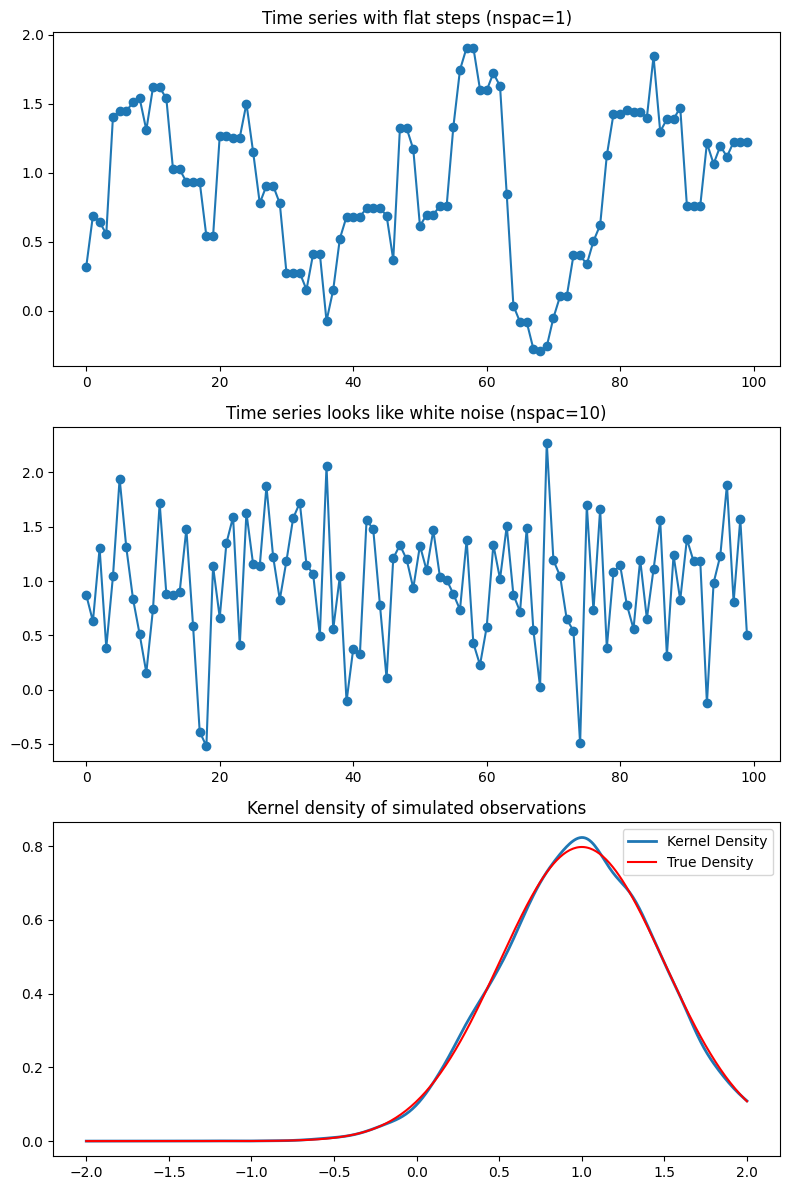

In [3]:

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# 1) Time series with flat steps: nbatch=100, nspac=1
chain1 = metropolis(h, initial=0, n_samples=100, n_spac=1)
axes[0].plot(chain1, linestyle='-', marker='o')
axes[0].set_title("Time series with flat steps (nspac=1)")

# 2) Time series with reduced serial correlation: nbatch=100, nspac=10
chain2 = metropolis(h, initial=0, n_samples=100, n_spac=10)
axes[1].plot(chain2, linestyle='-', marker='o')
axes[1].set_title("Time series looks like white noise (nspac=10)")

# 3) Density estimate versus true density: nbatch=10000, nspac=10
chain3 = metropolis(h, initial=0, n_samples=10000, n_spac=10)
density = gaussian_kde(chain3)
xbase = np.linspace(-2, 2, 400)
axes[2].plot(xbase, density(xbase), lw=2, label="Kernel Density")
axes[2].plot(xbase, norm.pdf(xbase, loc=1, scale=0.5), color='red', label="True Density")
axes[2].set_title("Kernel density of simulated observations")
axes[2].legend()

plt.tight_layout()
plt.show()

### Outcomes

* The first panel is a time series where
the marginal distribution of each observations follows $N(1,0.5^2)$. 
  * Time dependence is visible
  * flat regions are observed when the Markov chain rejects a new proposal
so the value does not update over two periods. 

* The middle panel collects the time series every 10 observations on the Markov chain
  * serial correlation is weakened
  * No flat region is observed
 
  
* The third panel compares     
  * kernel density of the simulated observations (black curve) 
  * density function of $N(1,0.5^2)$ (red curve).


### Bayesian Inference


* Bayesian framework offers a coherent and natural language for statistical decision. 
* Bayesian views both the data $\mathbf{X}_{n}$ and the
parameter $\theta$ as random variables
* Before observeing the data, researcher holds a *prior distribution* $\pi$ about $\theta$
* After observing the data, researcher updates the prior distribution to a *posterior distribution* $p(\theta|\mathbf{X}_{n})$. 


### Bayes Theorem

* Let $f(\mathbf{X}_{n}|\theta)$ be the likelihood
* Let $\pi$ be the prior

* The celebrated Bayes Theorem is

$$
p(\theta|\mathbf{X}_{n})\propto f(\mathbf{X}_{n}|\theta)\pi(\theta)
$$




### Classical Analytical Example 

* $\mathbf{X}_{n}=(X_{1},\ldots,X_{n})$ is an iid sample drawn from a normal distribution with unknown $\theta$ and known $\sigma$
* If a researcher's prior distribution
$\theta\sim N(\theta_{0},\sigma_{0}^{2})$, her posterior distribution
is, by some routine calculation, also a normal distribution

$$
p(\theta|\mathbf{x}_{n})\sim N\left(\tilde{\theta},\tilde{\sigma}^{2}\right),
$$

where
$\tilde{\theta}=\frac{\sigma^{2}}{n\sigma_{0}^{2}+\sigma^{2}}\theta_{0}+\frac{n\sigma_{0}^{2}}{n\sigma_{0}^{2}+\sigma^{2}}\bar{x}$
and
$\tilde{\sigma}^{2}=\frac{\sigma_{0}^{2}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^{2}}$.


### Bayesian Credible Set

$$
\left(\tilde{\theta}-z_{1-\alpha/2}\cdot\tilde{\sigma},\ \tilde{\theta}+z_{1-\alpha/2}\cdot\tilde{\sigma}\right).
$$

* Posterior distribution depends on $\theta_{0}$ and $\sigma_{0}^{2}$
from the prior. 
* When the sample size is sufficiently, the data overwhelms the prior


### Frequentist Confidence Internval


* $\hat{\theta}=\bar{x}\sim N(\theta,\sigma^{2}/n)$. 

* Confidence interval is

$$
\left(\bar{x}-z_{1-\alpha/2}\cdot\sigma/\sqrt{n},\ \bar{x}-z_{1-\alpha/2}\cdot\sigma/\sqrt{n}\right).
$$

### Comparison

* Bayesian produces a posterior distribution
  * The posterior distribution implies point estimates and credible set
  * Data are fixed (invariant)
  * A prior distribution is needed

* Frequestist produces a point estimator
  * Before data are observed, the point estimator is random
  * Inference is imply by the point estimator **before observation**
  * Only data are realized, the point estimate is a fixed number
  * No prior distribution is needed
  

### Code Example

* Prior distribution $\mu \sim Beta(2,5)$
* [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is flexible

* The nature generates data

* The researcher correctly specifies the normal model
* Given the data, she infers $\theta$ according to the posterior distribution

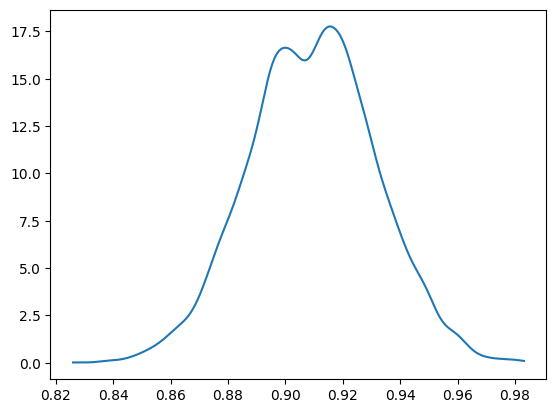

[0.86660764 0.95123674]


In [ ]:
from scipy.stats import beta

n = 2000

# generate n random numbers from a normal distribution
x = np.random.normal(loc=.9, scale=1, size=n)


def loglik(theta):
    # Computes the sum of log densities of x ~ N(theta, 1)
    return np.sum(norm.logpdf(x, loc=theta, scale=1))

def posterior(theta):
    # Adds the log density of a Beta(2,2) prior to the log-likelihood
    return loglik(theta) + beta.logpdf(theta, a=2, b=2)

nbatch = 10000
out = metropolis(posterior, initial=0.1, n_samples=nbatch, n_spac=10)
burn_in = round(nbatch / 10)
out = out[burn_in:]  # remove the burn-in period

# Plot the kernel density of the posterior draws
density_est = gaussian_kde(out)
x_grid = np.linspace(out.min(), out.max(), 200)
plt.figure()
plt.plot(x_grid, density_est(x_grid))
plt.show()

# Print the 95% quantile interval
print(np.quantile(out, [0.025, 0.975]))